<font size="8"> **Calculating distance to coastline** </font>  
To define the Antarctic coastline, we will first identify land areas. Land areas must meet two conditions:  
1. Grid cells must not contain any ocean or sea ice data (i.e., grid cell contains `NaN` values).
2. Grid cells must be located south from the maximum sea ice extent during the study period.

We will use monthly sea ice concentration (`aice_m`), a two-dimensional outputs to identify the location of the Antarctic coastline.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading modules

In [2]:
#Accessing model data
import cosima_cookbook as cc
#Dealing with data
import xarray as xr
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
#Collection of useful functions developed for this project
import UsefulFunctions as uf
#Useful package to deal with file paths
from glob import glob
#Parallelising work
from dask.distributed import Client
#Spatial analysis (extracting contour lines)
import rioxarray
from osgeo import osr
from osgeo import ogr
from osgeo import gdal
import geopandas as gp
from shapely.geometry import Point
from sklearn.neighbors import BallTree

# Defining dictionary of useful variables
In this dictionary we will define a variables that will be used multiple times throughout this notebook to avoid repetition. It will mostly contain paths to folders where intermediate or final outputs will be stored.

In [3]:
varDict = {'var_mod': 'aice_m',
           'model': 'ACCESS-OM2-01',
           'exp': '01deg_jra55v140_iaf_cycle4',
           'freq': '1 monthly',
           'base_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'}

# Creating a session in the COSIMA cookbook

In [13]:
session = cc.database.create_session()

# Accessing ACCESS-OM2-01 data
First, we will start a cluster with multiple cores to make analysis faster. Remember the number of CPUs cannot exceed the CPUs you have access to.

In [4]:
client = Client()
client

2023-05-16 16:55:33,300 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83871833.gadi-pbs/dask-worker-space/worker-fut5q8w0', purging
2023-05-16 16:55:33,300 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83871833.gadi-pbs/dask-worker-space/worker-xwd_qfse', purging
2023-05-16 16:55:33,301 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83871833.gadi-pbs/dask-worker-space/worker-tbn324a_', purging
2023-05-16 16:55:33,301 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83871833.gadi-pbs/dask-worker-space/worker-vl_cd02m', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42467,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:34919,Total threads: 3
Dashboard: /proxy/34505/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:37017,


We will use the sea ice concentration data (`aice_m`) to identify the Antarctic coastline. We will only keep coastlines that are present southwards from the maximum sea ice extent within our study period (1978-2019).  
  
We will load the monthly sea ice data and calculate the maximum sea ice extent by obtaining the maximum sea ice concentration value within each pixel.

In [15]:
var_ice = uf.getACCESSdata_SO(varDict['var_mod'], '1978-01', '2019-01', 
                              freq = varDict['freq'], ses = session, 
                              exp = varDict['exp'], ice_data = True)
var_ice = uf.corrlong(var_ice)
var_ice

<xarray.DataArray 'aice_m' (time: 493, yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(493, 740, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 ... 2018-12-31T12:00:00
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

## Calculating maximum sea ice extent

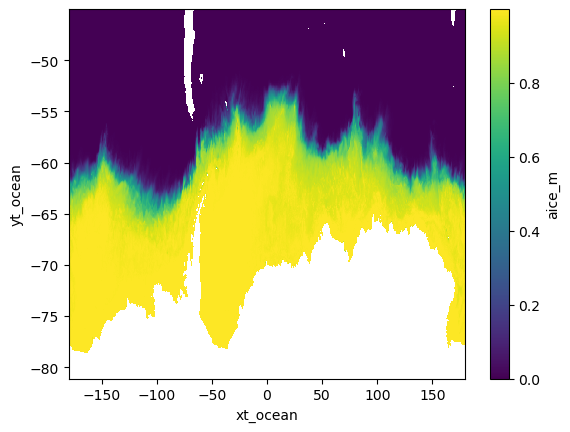

In [16]:
max_ice = var_ice.max('time')
max_ice.plot()

## Creating boolean mask from maximum sea ice extent
Areas where sea ice was present are given a value of `1`, any other areas are assigned a `0`.

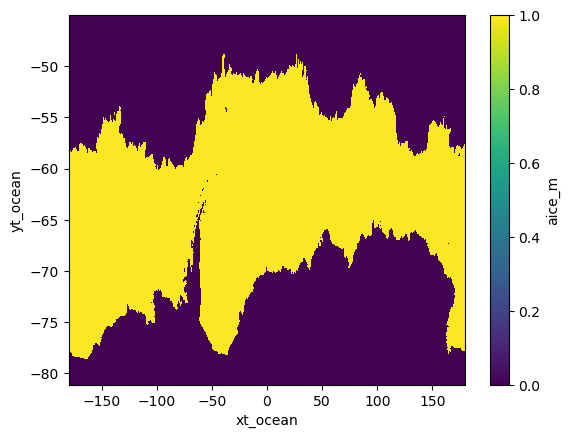

In [17]:
thresh = xr.where(max_ice > 0, True, False)
thresh.plot()

## Getting a land mask
We will assign a value of `1` to land areas and `0` to ocean areas. We will use the first time step in the sea ice data. However, we can use any timestep as the land mask remains the same in the model regardless of time. 

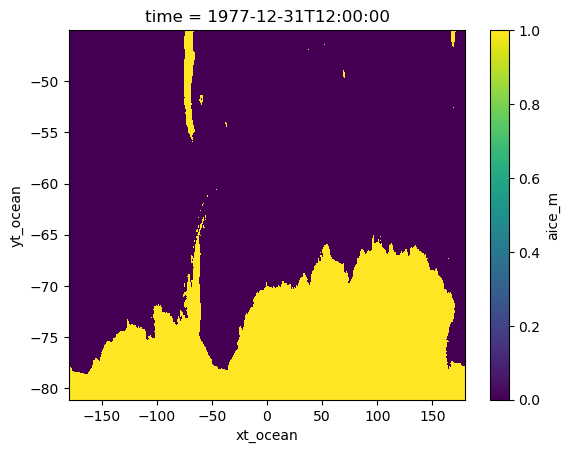

In [18]:
mask = xr.where(np.isnan(var_ice.isel(time = 0)), True, False)
mask.plot()

### Correcting land mask
Our land mask will only include land areas south of the maximum sea ice extent. We will use the boolean sea ice extent mask to do this. 
  
Any land areas beyond the maximum sea ice extent will be given a value of `2`. While any areas south from the maximum sea ice extent will be given a value of `1`.  
  
This will leave land areas south of the maximum sea ice extent that are relevant to crabeater seal distribution.

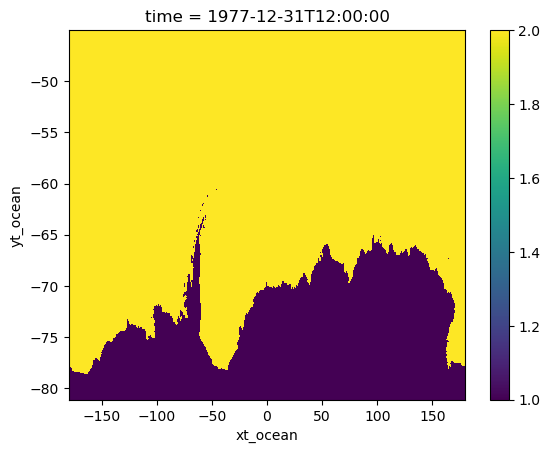

In [19]:
#The mask will consider only values north from 60S, which is roughly the southermost latitude
#where sea ice was present at least once in our study period.
mask = xr.where((thresh.yt_ocean >= -60) & (thresh == 0), 2, mask)
mask = mask.where(mask != 0, 2)
#Checking results
mask.plot()

In the figure above, the coastline is represented by the boundary between the purple and yellow areas surrounding the Antarctic continent.  

# Saving data 
Before we can extract the contour of our interest, we need to assign a coordinate reference system (CRS) to our new data array and save it in `tif` format.

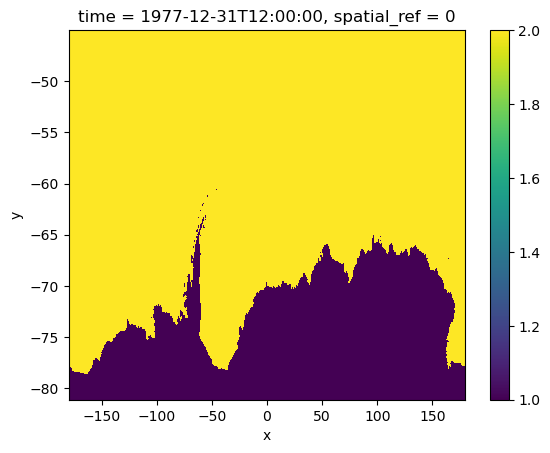

In [20]:
#Assign CRS - EPSG 4326 uses coordinates and its datum is WGS84.
mask.rio.write_crs('epsg:4326', inplace = True)
#Renaming x and y axes so file can be recognised by spatial processing libraries
mask = mask.rename({'yt_ocean': 'y', 'xt_ocean': 'x'})
#Checking result - It should match the plot above 
mask.plot()

In [21]:
#Ensuring folder where outputs will be saved exists
os.makedirs(varDict['base_folder'], exist_ok = True)

#Saving our data array as tif
mask.rio.to_raster(os.path.join(varDict['base_folder'], 'Coastline_Contour_Mask.tif'))

# Identifying contour for continental shelf
For this section, we will use the `gdal` package for spatial analysis.

## Load `tif` file

In [33]:
#Load raster
raster = gdal.Open(os.path.join(varDict['base_folder'], 'Coastline_Contour_Mask.tif'))
#Load first time step
rasterBand = raster.GetRasterBand(1)
#Get CRS information
proj = osr.SpatialReference(wkt = raster.GetProjection())

## Check values in `tif` file

In [34]:
#Load values as numpy array
vals = raster.ReadAsArray()

#Check maximum and minimum values (should be 1 and 2)
print('minimum:', vals.min(), 'maximum:', vals.max())

minimum: 1 maximum: 2


## Create a shapefile where we will store our contour line
Note that we will create a shapefile containing two columns: `ID` and `coastline`. These two columns are required by `gdal` to create a contour. In our case, the `coastline` column indicates the boundary of the continental shelf, and `ID` is a unique number identifying each line created.

In [35]:
#Provide full file path to where shapefile will be saved
contourPath = os.path.join(varDict['base_folder'], 'coastline_contour.shp')

#Start a new shapefile
contourDs = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(contourPath)
#Intermediary shapefile
contourShp = contourDs.CreateLayer('contour', proj)
#Creating two columns: ID and elevation
fieldDef = ogr.FieldDefn('ID', ogr.OFTInteger)
contourShp.CreateField(fieldDef)
fieldDef = ogr.FieldDefn('coastline', ogr.OFTReal)
contourShp.CreateField(fieldDef)

0

## Create contour for continental edge
Contours will be drawn at the continental edge, which is represented by boundary between grid cells with a value of `1` and `2`. A single point will be created for each grid cell where the shelf was detected. Although this raster does not include `NaN` values, this information needs to be included for contours to be created.  
  
The line of code below will also save the contour lines to the local disk.

In [36]:
gdal.ContourGenerate(rasterBand, 1., 0., [], 1, noDataValue = np.nan, dstLayer = contourShp, idField = 0, elevField = 1)

0

We will remove the intermediary shapefile we no longer need.

In [37]:
contourDs.Destroy()

## Checking results
We will load the newly created shapefile with `geopandas` and plot it to check the results.

In [41]:
#Load shapefile
coastline_contour = gp.read_file(os.path.join(varDict['base_folder'], 'coastline_contour.shp'))

#Check contents
coastline_contour

,ID,coastline,geometry
0,0,2.0,"LINESTRING (169.75000 -72.12710, 169.85000 -72..."
1,1,2.0,"LINESTRING (-104.95000 -71.68779, -104.85000 -..."
2,2,2.0,"LINESTRING (170.25000 -69.73528, 170.35000 -69..."
3,3,2.0,"LINESTRING (163.75000 -68.80784, 163.85000 -68..."
4,4,2.0,"LINESTRING (163.45000 -68.66140, 163.55000 -68..."
5,5,2.0,"LINESTRING (-74.85000 -67.92921, -74.75000 -67..."
6,6,2.0,"LINESTRING (36.65000 -67.48990, 36.75000 -67.5..."
7,7,2.0,"LINESTRING (-68.45000 -67.24583, -68.35000 -67..."
8,8,2.0,"LINESTRING (-90.55000 -66.90415, -90.45000 -66..."
9,9,2.0,"LINESTRING (-90.65000 -66.85533, -90.55000 -66..."


Plotting shapefile around Antarctic continent

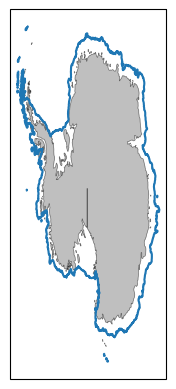

In [40]:
#Creating figure
fig = plt.figure()
#Assigning South Pole Stereographic projection
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())

#Getting land mask with slight transparency
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5, alpha = 0.5)

#Plotting contour and land
coastline_contour.plot(ax = ax, transform = ccrs.PlateCarree())
ax.add_feature(land)

Although the coastline boundary does not match perfectly the coastline in the shapefile, the boundary in blue shows the location of the coastline in the model grid.

# Calculating distance to closest point along Antarctic coastline grid cell
We will apply the following steps to get the distance from each grid cell to the continental shelf:
1. Get coordinate pairs for all points along the Antarctic coastline,
2. Get coordinate pairs for original dataset to calculate distances to closest coastline point,
3. Use Nearest Neighbour algorithm (`BallTree`) to calculate distance to closest coastline,
4. Transform distance from radians to kilometers and store result in a data array,
5. Save output to disk (optional).

## Extracting coordinate pairs for each point along coastline contour

In [41]:
#Empty list to store latitude and coordinate pairs
lon = []
lat = []

#Looping through every row in the shelf contour shapefile
for index, row in coastline_contour.iterrows():
    #Extracting coordinates for each point along each row
    for point in list(row.geometry.coords):
        #Saving coordinates to empty variables
        lon.append(point[0])
        lat.append(point[1])
        
#Create coordinate pairs for each point along the continental shelf break
coastline_coords = np.vstack([lat, lon]).T
coastline_coords

array([[ -72.12710117, -190.25      ],
       [ -72.17591379, -190.1500001 ],
       [ -72.22472646, -190.1500001 ],
       ...,
       [ -57.67855202,  -45.85      ],
       [ -57.67855202,  -45.75      ],
       [ -57.67855202,  -45.65      ]])

## Getting coordinate pairs for each cell in the original grid
We will use the latitude and longitude values in our original data to create coordinate pairs. We will also need to transform coordinate pairs from coordinates to radians as this is needed in the calculation of distances.

In [42]:
#Storing longitude and latitude values
x, y = np.meshgrid(np.deg2rad(mask.x.values),
                   np.deg2rad(mask.y.values))

#Changing shape so there are two values per row
grid_coords = np.vstack([y.flat, x.flat]).T

#Removing variables not needed
del x, y

#Checking result
grid_coords

array([[-1.41561267, -4.88604924],
       [-1.41561267, -4.88430391],
       [-1.41561267, -4.88255858],
       ...,
       [-0.78602773,  1.39190008],
       [-0.78602773,  1.39364541],
       [-0.78602773,  1.39539074]])

## Applying Nearest Neighbour algorithm to calculate distance to closest Antarctic coastline

In [45]:
#Set up Ball Tree. Coordinates must be given in radians
balltree = BallTree(np.deg2rad(coastline_coords), metric = 'haversine')

#Calculate nearest neighbour distances. Function gives two outputs: distances (in radians) and indices
dist_rad, ind = balltree.query(grid_coords, return_distance = True)

## Transforming nearest neighbour distances from radians to kilometers
The `BallTree` algorithm calculates distances in radians, which we will transform into kilometers by multiplying by the Earth's radius in kilometers. We will also store the results in a data array to make any calculations easier.  
  
The new data array will have the same shape as our `mask` data array.

In [46]:
#Earth radius in km
earth_radius_km = 6371

#Transforming radians and reshaping data
dist_km = xr.DataArray(data = (dist_rad*earth_radius_km).reshape(mask.shape),
                           dims = ['yt_ocean', 'xt_ocean'],
                           coords = {'yt_ocean': mask.y.values,
                                     'xt_ocean': mask.x.values},
                           name = 'dist_km')
dist_km = dist_km.assign_attrs({'units': 'km',
                                'long_name': 'distance to nearest neighbour'})

## Plotting results
We will plot the distances calculated in the previous steps with the shelf contour line overlaid on top.

<AxesSubplot:xlabel='xt_ocean', ylabel='yt_ocean'>

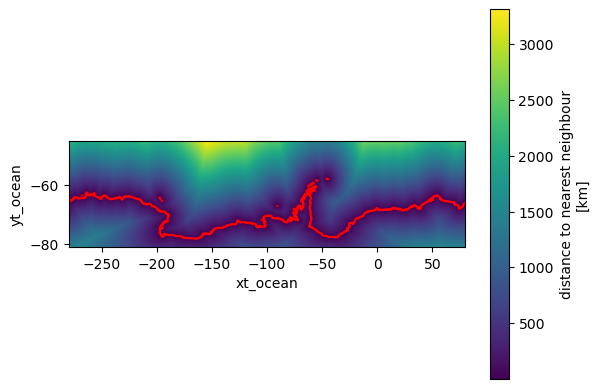

In [48]:
fig, ax = plt.subplots(1, 1)
p1 = dist_km.plot(ax = ax)
coastline_contour.plot(ax = ax, color = 'red')

# Saving results to disk

In [49]:
dist_km.to_netcdf(os.path.join(varDict['base_folder'], 'coastline_contour.nc'))